In [14]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import time
torch.manual_seed(seed=42) 
os.makedirs('./model_para', exist_ok=True)

In [15]:
class Mynetwork(nn.Module):
    def __init__(self,input_num=1 , out_num=1,hidden_num=128):
        super().__init__()
        self.MLP=nn.Sequential(
            nn.Linear(input_num, hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),       
            nn.Linear(hidden_num,hidden_num),
            nn.ELU(),   
            nn.Linear(hidden_num,out_num),
        )
        pass
    def forward(self,x):
        return self.MLP(x)

In [16]:
def potential(x,k,scale=100):
    # poten=-1/x*scale
    # return poten-k*(l+1)*l/x**2
    
    poten=-10/x+x
    return poten

In [17]:
#需要适当减小,x_M=sqrt(h_bar/(m*w)*(2n+1)),考虑要>10x_M,700sqrt(h_bar/\omega*m)
h_bar=1
m=1
b_lap:float=-h_bar**2/(2*m)

# 同时对于库伦势函数, 取e=1, 4\pi\epsilon_0=1, E_n=-1/(2n^2)
dtype=torch.float32
device=torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

La=0
Lb =40
L=Lb-La  # domain length
N = 800   # number of interior points # 对时间成本来说几乎是平方量级
h :float= L / (N+1)
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)

# 控制势函数的大小
l_max=1
scale=10

en_num=30
extend_num=10
epoch=200000
lr=0.01

diag = -2.0 / h**2 * torch.ones(N,device=device) * b_lap
off_diag = 1.0 / h**2 * torch.ones(N - 1,device=device) * b_lap

In [18]:
real_en_list=[]
for l in range(l_max):
    centrifugal_poten=-b_lap*(l+1)*l/grid**2
    V_diag=potential(grid,b_lap,scale)+centrifugal_poten
    A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
    eigenvalues= torch.linalg.eigvalsh(A)
    real_en=eigenvalues[:en_num].detach()
    real_en_list.append(real_en)

In [19]:
model=Mynetwork().to(device=device,dtype=dtype)
optimizer=torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,patience=80,threshold=1e-4)
loss_fn=nn.L1Loss()

loss_list=[]
init_time=time.time()
for i in range(epoch):
    optimizer.zero_grad()
    
    loss=0
    for l in range(l_max):
        centrifugal_poten=-b_lap*(l+1)*l/grid**2
        V_diag=model(grid)+centrifugal_poten
        A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
        eigenvalues= torch.linalg.eigvalsh(A)
        output=eigenvalues[:en_num]
        
        loss+=loss_fn(output,real_en_list[l])
    loss.backward()
    optimizer.step()
    
    loss_list.append(loss.item())
    if i%10==0:
        print(f'epoch:{i},loss:{loss},time:{time.time()-init_time},lr:{optimizer.param_groups[0]["lr"]}')
    
    if (i+1)%100==0:torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')
    scheduler.step(loss)
    if optimizer.param_groups[0]["lr"] <= 1.1e-8:break
    
final_loss=loss.item()
final_time=time.time()-init_time
final_epoch=i+1
print('terminal epoch: ',i+1)
torch.save(model.state_dict(),f'./model_para/model_para_{lr}.pth')


epoch:0,loss:11.131203651428223,time:0.013651132583618164,lr:0.01
epoch:10,loss:3.3003852367401123,time:0.12132477760314941,lr:0.01
epoch:20,loss:2.8715033531188965,time:0.21977448463439941,lr:0.01
epoch:30,loss:2.048100709915161,time:0.31374382972717285,lr:0.01
epoch:40,loss:1.5012093782424927,time:0.40666913986206055,lr:0.01


epoch:50,loss:1.1865781545639038,time:0.4951040744781494,lr:0.01
epoch:60,loss:0.4918332099914551,time:0.5833899974822998,lr:0.01
epoch:70,loss:0.9230912327766418,time:0.6711831092834473,lr:0.01
epoch:80,loss:0.6432442665100098,time:0.7677390575408936,lr:0.01
epoch:90,loss:0.20888414978981018,time:0.8630104064941406,lr:0.01
epoch:100,loss:0.8691107630729675,time:0.957810640335083,lr:0.01
epoch:110,loss:1.0392606258392334,time:1.0508544445037842,lr:0.01
epoch:120,loss:1.7801120281219482,time:1.145678997039795,lr:0.01
epoch:130,loss:0.8413032293319702,time:1.238264560699463,lr:0.01
epoch:140,loss:0.1985393911600113,time:1.3311553001403809,lr:0.01
epoch:150,loss:0.6693850755691528,time:1.4256160259246826,lr:0.01
epoch:160,loss:0.5401107668876648,time:1.5182580947875977,lr:0.01
epoch:170,loss:0.4482678771018982,time:1.6115219593048096,lr:0.01
epoch:180,loss:0.5911469459533691,time:1.7076754570007324,lr:0.01
epoch:190,loss:0.25800520181655884,time:1.8024022579193115,lr:0.001
epoch:200,loss:

In [20]:
# -1.5237e-01, -1.3085e-01, -1.2296e-01, -1.0179e-01, -7.9435e-02,
#         -5.6185e-02, -3.5326e-02, -1.0974e-02,  1.4396e-02,  4.2974e-02
# -1.2695e-01, -9.2922e-02, -5.8262e-02, -2.2549e-02,  1.4835e-02,
#          5.1943e-02,  9.0080e-02,  1.2834e-01,  1.6763e-01,  2.0718e-01

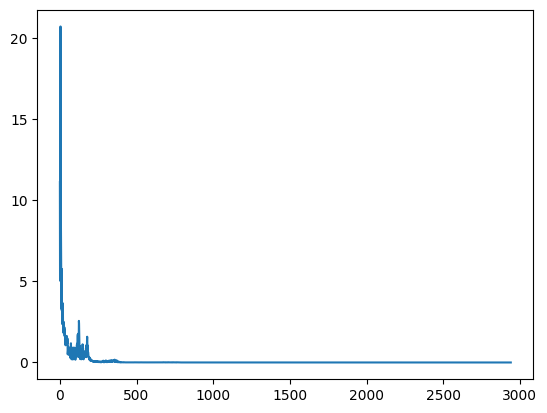

In [21]:
plt.plot(loss_list)
plt.show()

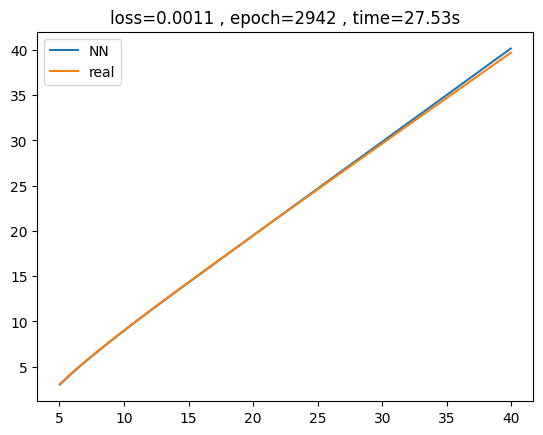

In [22]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[100:]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()


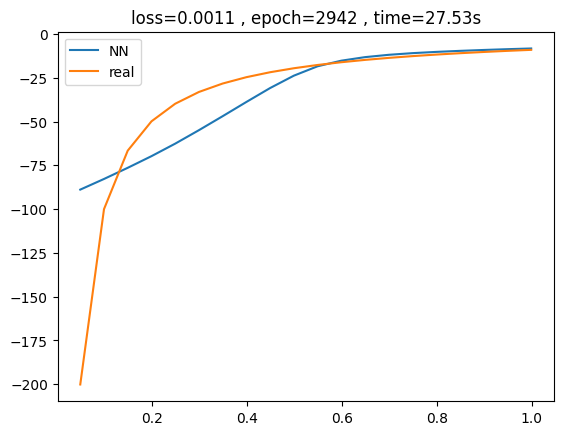

In [23]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
grid=grid[:20]
NN_poten=model(grid)
real_poten=potential(grid,b_lap,scale)
NN_poten=NN_poten.cpu().detach().numpy()
real_poten=real_poten.cpu().detach().numpy()
grid=grid.cpu().detach().numpy()
plt.plot(grid,NN_poten,label='NN')
plt.plot(grid,real_poten,label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

In [24]:
grid=torch.linspace(La,Lb,N+2,dtype=dtype,device=device)
grid=grid[1:-1].unsqueeze(-1)
V_diag=model(grid)
A = torch.diag(diag) + torch.diag(off_diag,diagonal=1) + torch.diag(off_diag, diagonal=-1)+torch.diag(V_diag.flatten())
eigenvalues= torch.linalg.eigvalsh(A)
output=eigenvalues[:en_num]

real_en=real_en_list[0]
error=output-real_en
rela_error=error/real_en
print('final error:',error)
print('relative error:',rela_error)

final error: tensor([ 7.2479e-05, -4.7684e-06,  9.5367e-07,  2.3544e-05,  2.3842e-06,
         1.2398e-05, -1.0014e-04,  2.0714e-03,  2.7084e-04, -1.2722e-03,
        -1.6441e-03, -1.1225e-03,  1.3351e-05,  8.6403e-04,  1.4706e-03,
         1.4534e-03,  9.3174e-04,  2.9182e-04, -4.7112e-04, -1.1349e-03,
        -1.6661e-03, -1.9779e-03, -2.0523e-03, -1.8654e-03, -1.3332e-03,
        -5.4932e-04,  5.3596e-04,  1.8864e-03,  3.5019e-03,  5.3425e-03],
       device='cuda:2', grad_fn=<SubBackward0>)
relative error: tensor([-1.5400e-06,  4.0716e-07, -2.2598e-07, -2.4673e-05,  2.1860e-06,
         4.7126e-06, -2.5632e-05,  4.1254e-04,  4.4945e-05, -1.8301e-04,
        -2.1035e-04, -1.3003e-04,  1.4191e-06,  8.5115e-05,  1.3534e-04,
         1.2578e-04,  7.6226e-05,  2.2671e-05, -3.4888e-05, -8.0377e-05,
        -1.1318e-04, -1.2920e-04, -1.2919e-04, -1.1339e-04, -7.8393e-05,
        -3.1295e-05,  2.9628e-05,  1.0132e-04,  1.8298e-04,  2.7186e-04],
       device='cuda:2', grad_fn=<DivBackward0

energy level while l=0


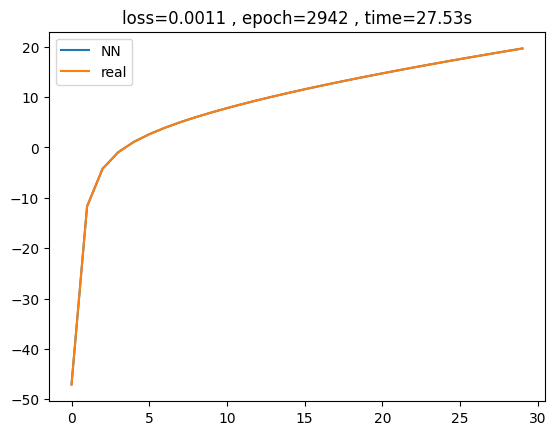

In [25]:
print('energy level while l=0')
plt.plot(output[:].detach().cpu().numpy(),label='NN')
plt.plot(real_en[:].detach().cpu().numpy(),label='real')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()

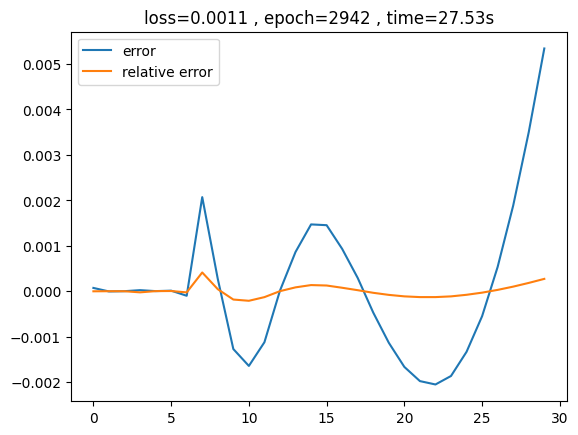

In [26]:
plt.plot(error.detach().cpu().numpy(),label='error')
plt.plot(rela_error.detach().cpu().numpy(),label='relative error')
plt.title(f'loss={final_loss:.4f} , epoch={final_epoch} , time={final_time:.2f}s')
plt.legend()
plt.show()